In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Quick check to make sure the versions we are using are up to date

import tensorflow as tf
print(tf.__version__)
print(pd.__version__)

1.12.0
0.23.4


In [44]:
# We can set all important variables at the start

main_folder = 'C://Users/karim/Desktop/'
images_folder = main_folder +'clean_AMLSdataset/'

EXAMPLE_PIC = images_folder + '1.png'
#EXAMPLE_PIC = 'C://Users/karim/1.png'


TRAINING_SAMPLES = 660
VALIDATION_SAMPLES = 170
TEST_SAMPLES = 170
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [17]:
# Import the csv file that includes the attribute for each picture
df_attr = pd.read_csv('clean_attribute_list.csv')
df_attr.set_index('file_name', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0

#Display shape of attribute list
df_attr.shape

(1000, 5)

In [18]:
# Display the list of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 hair_color
1 eyeglasses
2 smiling
3 young
4 human


smiling    1
young      1
human      0
Name: 1.png, dtype: int64

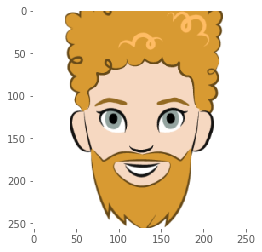

In [19]:
# An example plot that displays one of the 
# pictures in the dataset along with a couple of attributes

img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['smiling','young','human']] #some attributes

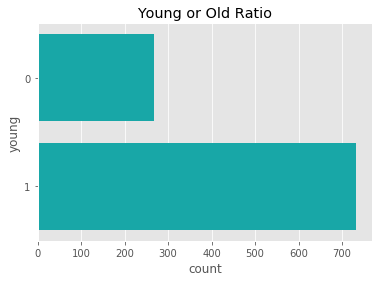

In [20]:
# Below we can have an idea about the consistency 
# of the attribute across the data

plt.title('Young or Old Ratio')
sns.countplot(y='young', data=df_attr, color="c")
plt.show()

In [38]:
#Import the csv file that includes the partition chosen for the model

df_partition = pd.read_csv('list_eval_partition_mediumset.csv')
df_partition

,file_name,partition
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0
5,6.png,0
6,7.png,0
7,8.png,0
8,9.png,0
9,10.png,0


In [39]:
# Display the partitions
# 0 -> Training set
# 1 -> Validation set
# 2 -> Test set

df_partition['partition'].value_counts().sort_index()

0    660
1    170
2    170
Name: partition, dtype: int64

In [40]:
# Below we join the partition dataframe with the attributes dataframe

df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['young'], how='inner')
print(df_par_attr.head(50))
print(df_par_attr.tail(50))
df_par_attr['young'].value_counts().sort_index()



           partition  young
file_name                  
1.png              0      1
2.png              0      1
3.png              0      0
4.png              0      0
5.png              0      0
6.png              0      0
7.png              0      1
8.png              0      1
9.png              0      1
10.png             0      0
11.png             0      0
12.png             0      1
13.png             0      1
14.png             0      1
15.png             0      0
16.png             0      0
17.png             0      1
18.png             0      1
19.png             0      1
20.png             0      1
21.png             0      0
22.png             0      1
23.png             0      1
24.png             0      0
25.png             0      1
26.png             0      1
27.png             0      0
28.png             0      1
29.png             0      0
30.png             0      0
31.png             0      1
32.png             0      0
33.png             0      1
34.png             0

0    267
1    733
Name: young, dtype: int64

In [42]:
dftest = df_par_attr[(df_par_attr['partition'] == 0)] 
dftest

,partition,young
file_name,,
1.png,0,1
2.png,0,1
3.png,0,0
4.png,0,0
5.png,0,0
6.png,0,0
7.png,0,1
8.png,0,1
9.png,0,1


In [43]:
dftest['young'].value_counts().sort_index()

0    175
1    485
Name: young, dtype: int64

In [11]:
#Function allowing us to load the image, turn it into an array and reshape it
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

#Function allowing us to generate the dataframe containing the features of images
# that will then be passed into the model for training purposes.
def generate_df_TRAIN(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/4))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)
    
    return x_, y_

In [12]:
#The same function is repeated due to the fact that the consistency of attributes is different in each partition set

#Function allowing us to generate the dataframe containing the features of images
# that will then be passed into the model for validation purposes.
def generate_df_VAL(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/5))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/4))])


    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)

    return x_, y_

In [13]:
#The same function is repeated due to the fact that the consistency of attributes is different in each partition set

#Function allowing us to generate the dataframe containing the features of images
# that will then be passed into the model for testing purposes.
def generate_df_TEST(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/4))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    x_ = []
    y_ = []

    for index, target in df_.iterrows():
        im = cv2.imread(images_folder + index)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

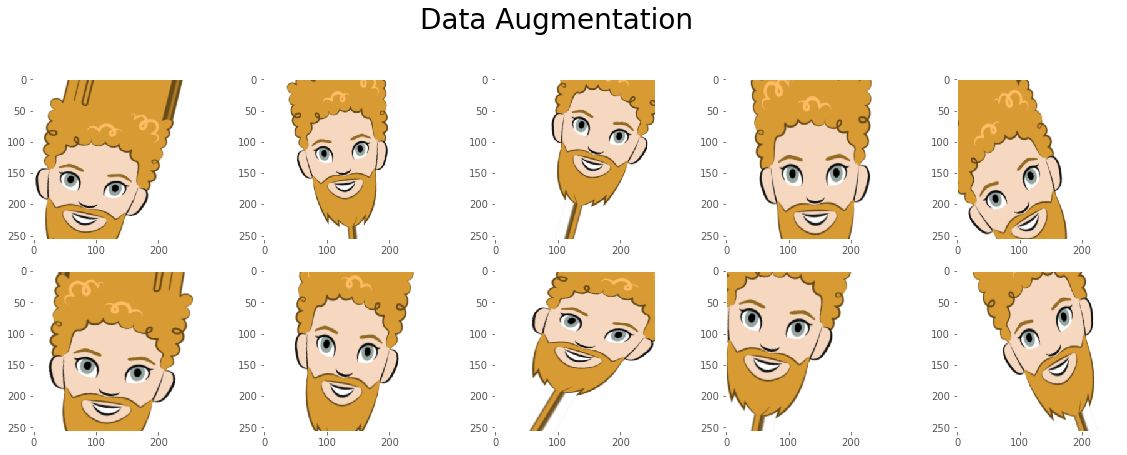

In [14]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded image
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(256, 256, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [15]:
# Here we generate the training data by sending the partition, here we have 0 which is equivalent to training set
# We send along as well the attribute and the number of training samples
x_train, y_train = generate_df_TRAIN(0, 'young', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [16]:
# Similar to before, here we generate the Validation Data. Therefore we send the number 1 in between the brackets. 
x_valid, y_valid = generate_df_VAL(1, 'young', VALIDATION_SAMPLES)


'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [17]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [18]:
# Adding custom Layers in order to tailor the 
# output for either Binary or Multiclass Classification

x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [19]:
#Creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

#Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

#Compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [20]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.young1.hdf5', 
                               verbose=1, save_best_only=True)

In [21]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20
42/41 [==============================] - 320s 8s/step - loss: 0.8338 - acc: 0.5203 - val_loss: 0.7629 - val_acc: 0.5526

Epoch 00001: val_loss improved from inf to 0.76293, saving model to weights.best.inc.young1.hdf5
Epoch 2/20
42/41 [==============================] - 319s 8s/step - loss: 0.6392 - acc: 0.6811 - val_loss: 0.7061 - val_acc: 0.5658

Epoch 00002: val_loss improved from 0.76293 to 0.70610, saving model to weights.best.inc.young1.hdf5
Epoch 3/20
42/41 [==============================] - 312s 7s/step - loss: 0.5840 - acc: 0.7075 - val_loss: 0.7130 - val_acc: 0.5789

Epoch 00003: val_loss did not improve from 0.70610
Epoch 4/20
42/41 [==============================] - 317s 8s/step - loss: 0.5556 - acc: 0.7389 - val_loss: 0.7055 - val_acc: 0.6053

Epoch 00004: val_loss improved from 0.70610 to 0.70551, saving model to weights.best.inc.young1.hdf5
Epoch 5/20
42/41 [==============================] - 317s 8s/step - loss: 0.5593 - acc: 0.7499 - val_loss: 0.6906 - val_acc

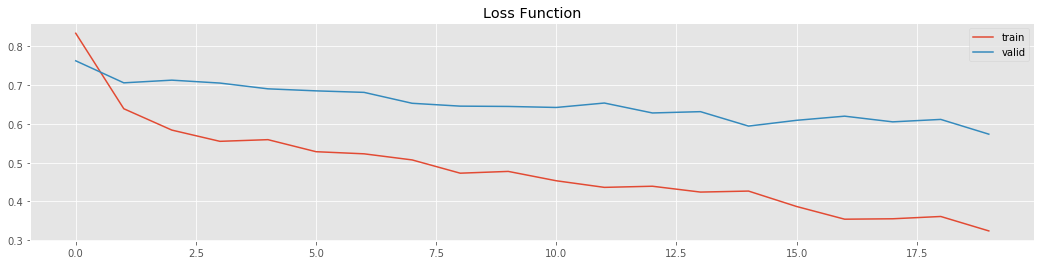

In [22]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

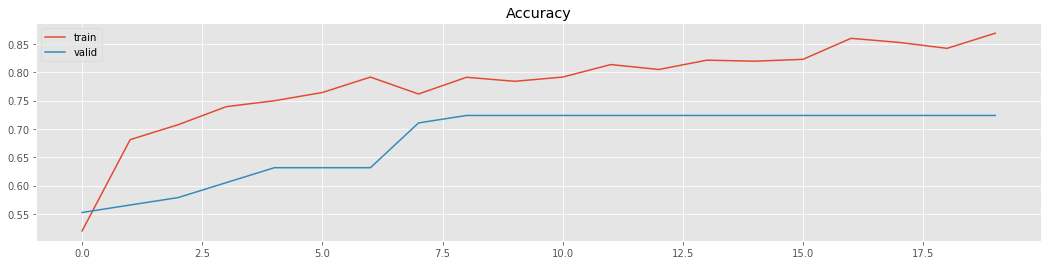

In [23]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [24]:
#load the best model
model_.load_weights('weights.best.inc.young1.hdf5')

In [25]:
# Similar to before, here we generate the Testing Data. Therefore we send the number 2 in between the brackets. 
x_test, y_test = generate_df_TEST(2, 'young', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 79.5276%
f1_score: 0.8673469387755102


In [3]:
#dictionary to name the prediction
attribute_target = {0: 'Old'
                , 1: 'Young'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display results in HTML for better visualisation
    
    '''

    attribute = 'Young'
    arrow_icon = "https://i.imgur.com/nxWan2u.png"
    
    #print(prediction)
    
    if prediction[1] <= 0.5:
        arrow_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Old'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 5px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 10px; font-size: 10px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 25px; font-size: 10px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , arrow_icon
               , attribute
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , attribute_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [4]:
def attribute_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

In [5]:
import csv

#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(5)

with open('persons.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)

    for index, target in df_to_test.iterrows():
        result = attribute_prediction(images_folder + index)
        print(result[0])
        highest_pred= np.amax(result)
        print(highest_pred)

        pred_arr = result[0]
        print(pred_arr[1])
        
        #filewriter.writerow(['Name', 'Profession'])
        
        #display result
        display_result(images_folder + index, result[0], target['eyeglasses'])

        print(index)

        if pred_arr[1] <= 0.5:
            negative = int(-1)
            print(negative)
            print('HELL YEAH')
            filewriter.writerow([index, negative])
        else:
            positive = int(1)
            print(positive)
            filewriter.writerow([index, positive])




NameError: name 'df_par_attr' is not defined